In [64]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [65]:
train_data = pd.read_csv('loan_train.csv')
test_data = pd.read_csv('loan_test.csv')

In [51]:
train_data.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,42788,21,102000,MORTGAGE,5.0,EDUCATION,A,10000,7.51,0.10,N,4,0
1,11553,23,49000,RENT,1.0,HOMEIMPROVEMENT,D,5000,13.17,0.10,Y,4,1
2,27481,23,30000,RENT,1.0,MEDICAL,B,10000,11.99,0.33,N,4,1
3,39841,32,95000,MORTGAGE,9.0,HOMEIMPROVEMENT,C,15000,12.84,0.16,Y,5,0
4,55662,31,32000,MORTGAGE,3.0,HOMEIMPROVEMENT,A,1200,7.68,0.04,N,10,0


In [66]:
X_train = train_data.drop('loan_status', axis=1)  # loan_status - целевая переменная
y_train = train_data['loan_status']
X_test = test_data.drop('loan_status', axis=1)
y_test = test_data['loan_status']

In [9]:
print(train_data.dtypes)

id                              int64
person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
loan_status                     int64
dtype: object


In [67]:
categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_cols),  # Применяем OneHotEncoder к категориальным столбцам
        ('num', StandardScaler(), X_train.select_dtypes(include=['int64', 'float64']).columns)  # Масштабируем числовые признаки
    ])

In [68]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [69]:
X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)

In [70]:
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)

In [56]:
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [71]:
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

Эксперимент 1. Простая модель

In [58]:
class SimpleModel(nn.Module):
    def __init__(self, input_size, hidden_size=32):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # Первый линейный слой
        self.fc2 = nn.Linear(hidden_size, hidden_size*4)  # Второй линейный слой
        self.fc3 = nn.Linear(hidden_size*4, 1)  # Выходной слой
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))  # Применяем ReLU после первого слоя
        x = self.relu(self.fc2(x))  # Применяем ReLU после второго слоя
        x = torch.sigmoid(self.fc3(x))  # Применяем Sigmoid для выхода в диапазоне [0, 1]
        return x.squeeze()

In [59]:
model = SimpleModel(input_size=X_train_processed.shape[1], hidden_size=32)

In [60]:
criterion = nn.BCELoss()  # Бинарная кросс-энтропия для бинарной классификации
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [72]:
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    train_losses = []
    test_losses = []
    train_roc_auc = []
    test_roc_auc = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            all_preds.append(outputs.detach().numpy())
            all_labels.append(labels.numpy())

        # Средний loss для train
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Вычисление ROC-AUC для train
        train_preds = np.concatenate(all_preds)
        train_labels = np.concatenate(all_labels)
        train_roc_auc_score = roc_auc_score(train_labels, train_preds)
        train_roc_auc.append(train_roc_auc_score)

        # Тестирование модели
        model.eval()
        test_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                all_preds.append(outputs.numpy())
                all_labels.append(labels.numpy())

        # Средний loss для test
        test_loss = test_loss / len(test_loader)
        test_losses.append(test_loss)

        # Вычисление ROC-AUC для test
        test_preds = np.concatenate(all_preds)
        test_labels = np.concatenate(all_labels)
        test_roc_auc_score = roc_auc_score(test_labels, test_preds)
        test_roc_auc.append(test_roc_auc_score)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, '
              f'Train ROC-AUC: {train_roc_auc_score:.4f}, Test ROC-AUC: {test_roc_auc_score:.4f}')

    # Построение графиков
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_roc_auc, label='Train ROC-AUC')
    plt.plot(test_roc_auc, label='Test ROC-AUC')
    plt.xlabel('Epoch')
    plt.ylabel('ROC-AUC')
    plt.legend()

    plt.show()


Epoch 1/10, Train Loss: 0.3453, Test Loss: 0.2612, Train ROC-AUC: 0.7959, Test ROC-AUC: 0.8965
Epoch 2/10, Train Loss: 0.2508, Test Loss: 0.2322, Train ROC-AUC: 0.8952, Test ROC-AUC: 0.9095
Epoch 3/10, Train Loss: 0.2335, Test Loss: 0.2213, Train ROC-AUC: 0.9049, Test ROC-AUC: 0.9150
Epoch 4/10, Train Loss: 0.2238, Test Loss: 0.2127, Train ROC-AUC: 0.9109, Test ROC-AUC: 0.9205
Epoch 5/10, Train Loss: 0.2160, Test Loss: 0.2068, Train ROC-AUC: 0.9159, Test ROC-AUC: 0.9236
Epoch 6/10, Train Loss: 0.2101, Test Loss: 0.2029, Train ROC-AUC: 0.9189, Test ROC-AUC: 0.9257
Epoch 7/10, Train Loss: 0.2052, Test Loss: 0.1983, Train ROC-AUC: 0.9212, Test ROC-AUC: 0.9276
Epoch 8/10, Train Loss: 0.2016, Test Loss: 0.1956, Train ROC-AUC: 0.9227, Test ROC-AUC: 0.9281
Epoch 9/10, Train Loss: 0.1982, Test Loss: 0.1931, Train ROC-AUC: 0.9241, Test ROC-AUC: 0.9292
Epoch 10/10, Train Loss: 0.1956, Test Loss: 0.1909, Train ROC-AUC: 0.9253, Test ROC-AUC: 0.9301


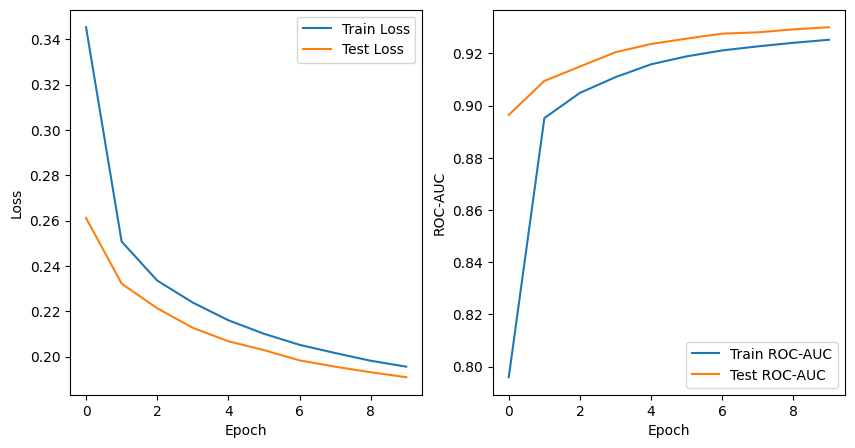

In [62]:
train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10)

Вывод: Модель улучшает свои результаты по мере обучения. Потери (Train и Test Loss) и ROC-AUC увеличиваются с каждой эпохой, точность улучшается. Улучшения становятся менее заметными после 9-й эпохи, что говорит о стабилизации. Оптимальное количество эпох — 10 или немного меньше, чтобы избежать переобучения.

Эксперимент 2. Модель побольше

In [77]:
class BiggerModel(nn.Module):
  def __init__(self, input_size, hidden_size=128):
    super(BiggerModel, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)

    # Блоки: Linear -> ReLU -> Linear
    self.block1 = nn.Sequential(
        nn.Linear(hidden_size, hidden_size*4),
        nn.ReLU(),
        nn.Linear(hidden_size*4, hidden_size)
        )

    self.block2 = nn.Sequential(
        nn.Linear(hidden_size, hidden_size*4),
        nn.ReLU(),
        nn.Linear(hidden_size*4, hidden_size)
        )

    self.block3 = nn.Sequential(
        nn.Linear(hidden_size, hidden_size*4),
        nn.ReLU(),
        nn.Linear(hidden_size*4, hidden_size)
        )

    self.fc4 = nn.Linear(hidden_size, 1)

  def forward(self, x):
    x = self.fc1(x)
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = torch.sigmoid(self.fc4(x))
    return x

In [78]:
model = BiggerModel(input_size=X_train_processed.shape[1], hidden_size=128)
optimizer = optim.SGD(model.parameters(), lr=0.01)

Epoch 1/10, Train Loss: 0.4032, Test Loss: 0.3038, Train ROC-AUC: 0.6800, Test ROC-AUC: 0.8879
Epoch 2/10, Train Loss: 0.2519, Test Loss: 0.2194, Train ROC-AUC: 0.8954, Test ROC-AUC: 0.9169
Epoch 3/10, Train Loss: 0.2135, Test Loss: 0.2010, Train ROC-AUC: 0.9154, Test ROC-AUC: 0.9249
Epoch 4/10, Train Loss: 0.1990, Test Loss: 0.1923, Train ROC-AUC: 0.9214, Test ROC-AUC: 0.9277
Epoch 5/10, Train Loss: 0.1918, Test Loss: 0.1875, Train ROC-AUC: 0.9249, Test ROC-AUC: 0.9278
Epoch 6/10, Train Loss: 0.1880, Test Loss: 0.1844, Train ROC-AUC: 0.9266, Test ROC-AUC: 0.9297
Epoch 7/10, Train Loss: 0.1854, Test Loss: 0.1855, Train ROC-AUC: 0.9280, Test ROC-AUC: 0.9284
Epoch 8/10, Train Loss: 0.1836, Test Loss: 0.1832, Train ROC-AUC: 0.9288, Test ROC-AUC: 0.9297
Epoch 9/10, Train Loss: 0.1819, Test Loss: 0.1828, Train ROC-AUC: 0.9296, Test ROC-AUC: 0.9309
Epoch 10/10, Train Loss: 0.1808, Test Loss: 0.1812, Train ROC-AUC: 0.9305, Test ROC-AUC: 0.9308


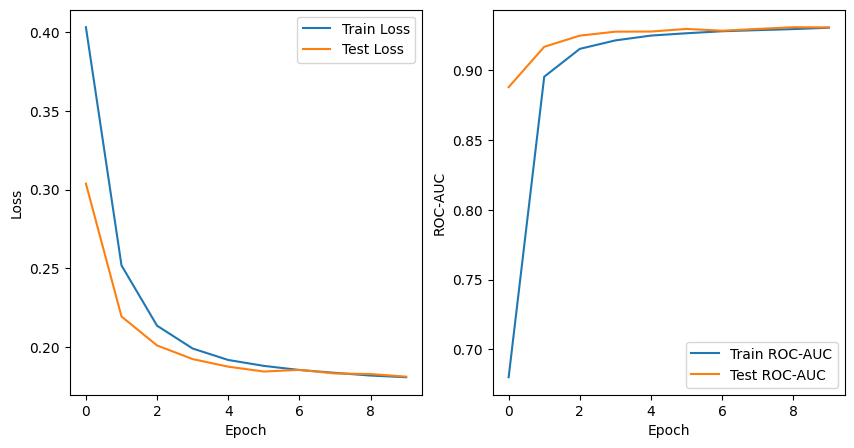

In [79]:
train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10)

Вывод: Модель стала лучше: вторая модель имеет более низкие значения потерь и более высокие значения ROC-AUC на обоих наборах данных, особенно в отношении ROC-AUC. Улучшения в обеих сериях заметны, но вторая модель демонстрирует более сильное улучшение, особенно по сравнению с начальными значениями.

Поведение модели: Модель продолжает улучшать свои показатели с каждой эпохой, но на последних эпохах прирост становится менее заметным, что указывает на стабилизацию

Эксперимент 3. Skip Connections, Batch Norms

In [82]:
class ModelWithBatchNormAndSkip(nn.Module):
    def __init__(self, input_size, hidden_size=128):
        super(ModelWithBatchNormAndSkip, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)

        # Блоки с skip-connection и BatchNorm
        self.block1 = nn.Sequential(
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, hidden_size*4),
            nn.ReLU(),
            nn.Linear(hidden_size*4, hidden_size)
        )

        self.block2 = nn.Sequential(
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, hidden_size*4),
            nn.ReLU(),
            nn.Linear(hidden_size*4, hidden_size)
        )

        self.block3 = nn.Sequential(
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, hidden_size*4),
            nn.ReLU(),
            nn.Linear(hidden_size*4, hidden_size)
        )

        self.fc4 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.fc1(x)

        residual = x
        x = self.block1(x)
        x += residual
        x = nn.ReLU()(x)

        residual = x
        x = self.block2(x)
        x += residual
        x = nn.ReLU()(x)

        residual = x
        x = self.block3(x)
        x += residual
        x = nn.ReLU()(x)

        x = torch.sigmoid(self.fc4(x))
        return x


In [83]:
model = ModelWithBatchNormAndSkip(input_size=X_train_processed.shape[1], hidden_size=128)
optimizer = optim.SGD(model.parameters(), lr=0.01)

Epoch 1/10, Train Loss: 0.2399, Test Loss: 0.2050, Train ROC-AUC: 0.8969, Test ROC-AUC: 0.9244
Epoch 2/10, Train Loss: 0.2014, Test Loss: 0.1942, Train ROC-AUC: 0.9220, Test ROC-AUC: 0.9271
Epoch 3/10, Train Loss: 0.1935, Test Loss: 0.1885, Train ROC-AUC: 0.9256, Test ROC-AUC: 0.9291
Epoch 4/10, Train Loss: 0.1882, Test Loss: 0.1821, Train ROC-AUC: 0.9288, Test ROC-AUC: 0.9291
Epoch 5/10, Train Loss: 0.1836, Test Loss: 0.1846, Train ROC-AUC: 0.9320, Test ROC-AUC: 0.9288
Epoch 6/10, Train Loss: 0.1826, Test Loss: 0.1809, Train ROC-AUC: 0.9326, Test ROC-AUC: 0.9298
Epoch 7/10, Train Loss: 0.1800, Test Loss: 0.1810, Train ROC-AUC: 0.9343, Test ROC-AUC: 0.9288
Epoch 8/10, Train Loss: 0.1785, Test Loss: 0.1815, Train ROC-AUC: 0.9352, Test ROC-AUC: 0.9302
Epoch 9/10, Train Loss: 0.1759, Test Loss: 0.1846, Train ROC-AUC: 0.9376, Test ROC-AUC: 0.9265
Epoch 10/10, Train Loss: 0.1737, Test Loss: 0.1886, Train ROC-AUC: 0.9385, Test ROC-AUC: 0.9245


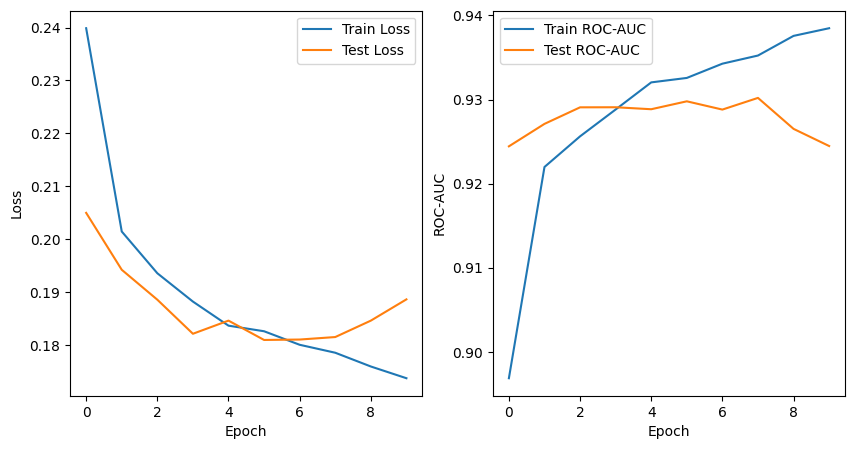

In [84]:
train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10)

В целом модель показывает улучшение на тренировочных данных (Train ROC-AUC), но на тестовых данных результаты стабилизировались. Модель на тесте показывает небольшие колебания в ROC-AUC, но в целом остается высокой.

Модель стабилизировалась в плане улучшения результатов на тестовых данных, но продолжает улучшаться на тренировочных. Это может указывать на небольшое переобучение, так как на тесте не наблюдается значительных улучшений.
Обе метрики (Loss и ROC-AUC) показывают стабильные результаты, что говорит о хорошем качестве модели, но стоит внимательно следить за возможным переобучением, если улучшения на тесте будут слабыми в будущем.

Эксперимент 4. Dropout

In [88]:
class ModelWithDropout(nn.Module):
    def __init__(self, input_size, hidden_size=128, dropout_prob=0.5):
        super(ModelWithDropout, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)

        # Блоки с skip-connection, BatchNorm и Dropout
        self.block1 = nn.Sequential(
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, hidden_size*4),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_size*4, hidden_size)
        )

        self.block2 = nn.Sequential(
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, hidden_size*4),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_size*4, hidden_size)
        )

        self.block3 = nn.Sequential(
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, hidden_size*4),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_size*4, hidden_size)
        )

        self.fc4 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.fc1(x)

        residual = x
        x = self.block1(x)
        x += residual
        x = nn.ReLU()(x)

        residual = x
        x = self.block2(x)
        x += residual
        x = nn.ReLU()(x)

        residual = x
        x = self.block3(x)
        x += residual
        x = nn.ReLU()(x)

        x = torch.sigmoid(self.fc4(x))
        return x

Epoch 1/10, Train Loss: 0.2634, Test Loss: 0.2061, Train ROC-AUC: 0.8788, Test ROC-AUC: 0.9253
Epoch 2/10, Train Loss: 0.2275, Test Loss: 0.1938, Train ROC-AUC: 0.9077, Test ROC-AUC: 0.9299
Epoch 3/10, Train Loss: 0.2164, Test Loss: 0.1870, Train ROC-AUC: 0.9130, Test ROC-AUC: 0.9324
Epoch 4/10, Train Loss: 0.2096, Test Loss: 0.1857, Train ROC-AUC: 0.9172, Test ROC-AUC: 0.9313
Epoch 5/10, Train Loss: 0.2052, Test Loss: 0.1839, Train ROC-AUC: 0.9196, Test ROC-AUC: 0.9330
Epoch 6/10, Train Loss: 0.2017, Test Loss: 0.1859, Train ROC-AUC: 0.9204, Test ROC-AUC: 0.9326
Epoch 7/10, Train Loss: 0.2000, Test Loss: 0.1873, Train ROC-AUC: 0.9209, Test ROC-AUC: 0.9298
Epoch 8/10, Train Loss: 0.1974, Test Loss: 0.1810, Train ROC-AUC: 0.9230, Test ROC-AUC: 0.9315
Epoch 9/10, Train Loss: 0.1949, Test Loss: 0.1809, Train ROC-AUC: 0.9235, Test ROC-AUC: 0.9316
Epoch 10/10, Train Loss: 0.1935, Test Loss: 0.1794, Train ROC-AUC: 0.9247, Test ROC-AUC: 0.9320


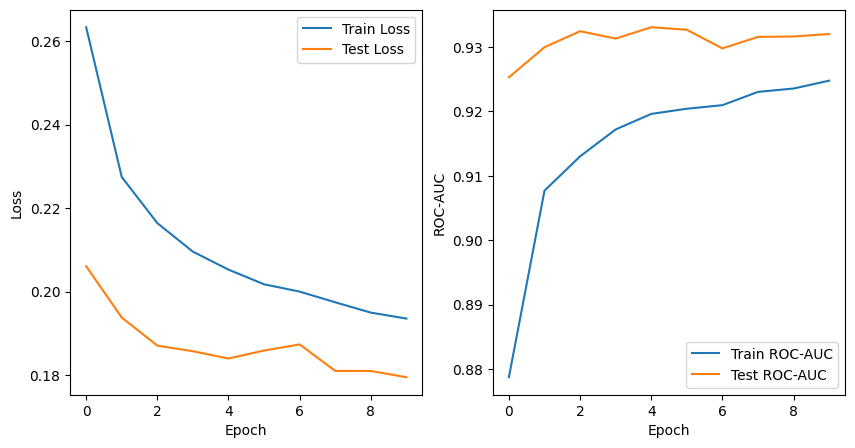

In [89]:
# Пример эксперимента с dropout_prob = 0.5
model = ModelWithDropout(input_size=X_train_processed.shape[1], hidden_size=128, dropout_prob=0.5)
optimizer = optim.SGD(model.parameters(), lr=0.01)
train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10)

Epoch 1/10, Train Loss: 0.2411, Test Loss: 0.2036, Train ROC-AUC: 0.8978, Test ROC-AUC: 0.9248
Epoch 2/10, Train Loss: 0.2014, Test Loss: 0.1898, Train ROC-AUC: 0.9226, Test ROC-AUC: 0.9279
Epoch 3/10, Train Loss: 0.1942, Test Loss: 0.1852, Train ROC-AUC: 0.9262, Test ROC-AUC: 0.9294
Epoch 4/10, Train Loss: 0.1898, Test Loss: 0.1846, Train ROC-AUC: 0.9287, Test ROC-AUC: 0.9272
Epoch 5/10, Train Loss: 0.1870, Test Loss: 0.1806, Train ROC-AUC: 0.9299, Test ROC-AUC: 0.9301
Epoch 6/10, Train Loss: 0.1846, Test Loss: 0.1851, Train ROC-AUC: 0.9318, Test ROC-AUC: 0.9268
Epoch 7/10, Train Loss: 0.1823, Test Loss: 0.1827, Train ROC-AUC: 0.9333, Test ROC-AUC: 0.9301
Epoch 8/10, Train Loss: 0.1800, Test Loss: 0.1863, Train ROC-AUC: 0.9340, Test ROC-AUC: 0.9255
Epoch 9/10, Train Loss: 0.1793, Test Loss: 0.1811, Train ROC-AUC: 0.9356, Test ROC-AUC: 0.9311
Epoch 10/10, Train Loss: 0.1771, Test Loss: 0.1852, Train ROC-AUC: 0.9370, Test ROC-AUC: 0.9266


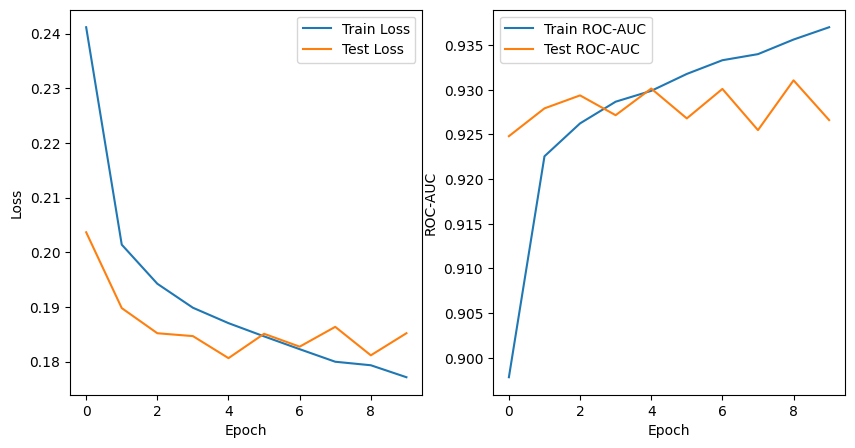

In [90]:
# Пример изменения dropout_prob на 0.01
model = ModelWithDropout(input_size=X_train_processed.shape[1], hidden_size=128, dropout_prob=0.01)
optimizer = optim.SGD(model.parameters(), lr=0.01)
train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10)


Epoch 1/10, Train Loss: 0.2469, Test Loss: 0.1958, Train ROC-AUC: 0.8926, Test ROC-AUC: 0.9251
Epoch 2/10, Train Loss: 0.2073, Test Loss: 0.1883, Train ROC-AUC: 0.9192, Test ROC-AUC: 0.9269
Epoch 3/10, Train Loss: 0.1980, Test Loss: 0.1836, Train ROC-AUC: 0.9236, Test ROC-AUC: 0.9298
Epoch 4/10, Train Loss: 0.1924, Test Loss: 0.1861, Train ROC-AUC: 0.9268, Test ROC-AUC: 0.9272
Epoch 5/10, Train Loss: 0.1899, Test Loss: 0.1809, Train ROC-AUC: 0.9270, Test ROC-AUC: 0.9309
Epoch 6/10, Train Loss: 0.1867, Test Loss: 0.1798, Train ROC-AUC: 0.9299, Test ROC-AUC: 0.9303
Epoch 7/10, Train Loss: 0.1857, Test Loss: 0.1801, Train ROC-AUC: 0.9307, Test ROC-AUC: 0.9307
Epoch 8/10, Train Loss: 0.1833, Test Loss: 0.1810, Train ROC-AUC: 0.9318, Test ROC-AUC: 0.9292
Epoch 9/10, Train Loss: 0.1815, Test Loss: 0.1820, Train ROC-AUC: 0.9331, Test ROC-AUC: 0.9273
Epoch 10/10, Train Loss: 0.1813, Test Loss: 0.1767, Train ROC-AUC: 0.9326, Test ROC-AUC: 0.9318


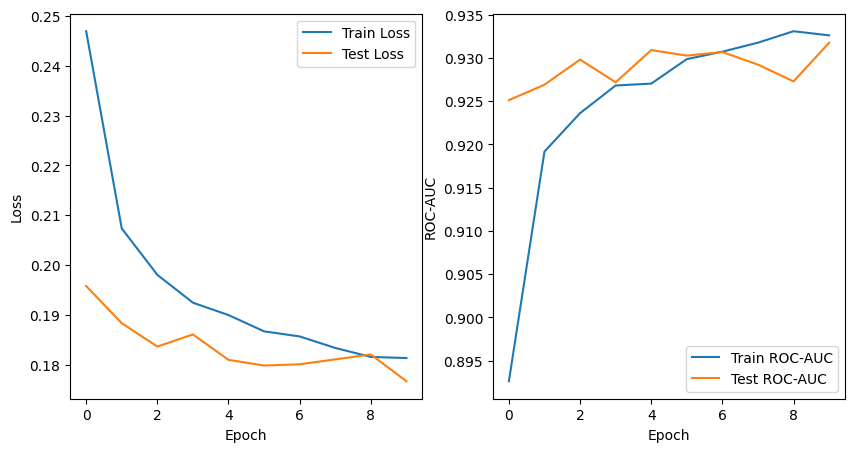

In [91]:
# Пример изменения dropout_prob на 0.1
model = ModelWithDropout(input_size=X_train_processed.shape[1], hidden_size=128, dropout_prob=0.1)
optimizer = optim.SGD(model.parameters(), lr=0.01)
train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10)

Epoch 1/10, Train Loss: 0.2432, Test Loss: 0.1971, Train ROC-AUC: 0.8954, Test ROC-AUC: 0.9276
Epoch 2/10, Train Loss: 0.2088, Test Loss: 0.1932, Train ROC-AUC: 0.9180, Test ROC-AUC: 0.9290
Epoch 3/10, Train Loss: 0.2007, Test Loss: 0.1871, Train ROC-AUC: 0.9214, Test ROC-AUC: 0.9292
Epoch 4/10, Train Loss: 0.1959, Test Loss: 0.1831, Train ROC-AUC: 0.9250, Test ROC-AUC: 0.9294
Epoch 5/10, Train Loss: 0.1932, Test Loss: 0.1808, Train ROC-AUC: 0.9261, Test ROC-AUC: 0.9304
Epoch 6/10, Train Loss: 0.1900, Test Loss: 0.1882, Train ROC-AUC: 0.9272, Test ROC-AUC: 0.9285
Epoch 7/10, Train Loss: 0.1883, Test Loss: 0.1824, Train ROC-AUC: 0.9286, Test ROC-AUC: 0.9305
Epoch 8/10, Train Loss: 0.1877, Test Loss: 0.1859, Train ROC-AUC: 0.9279, Test ROC-AUC: 0.9294
Epoch 9/10, Train Loss: 0.1859, Test Loss: 0.1850, Train ROC-AUC: 0.9300, Test ROC-AUC: 0.9291
Epoch 10/10, Train Loss: 0.1830, Test Loss: 0.1888, Train ROC-AUC: 0.9322, Test ROC-AUC: 0.9252


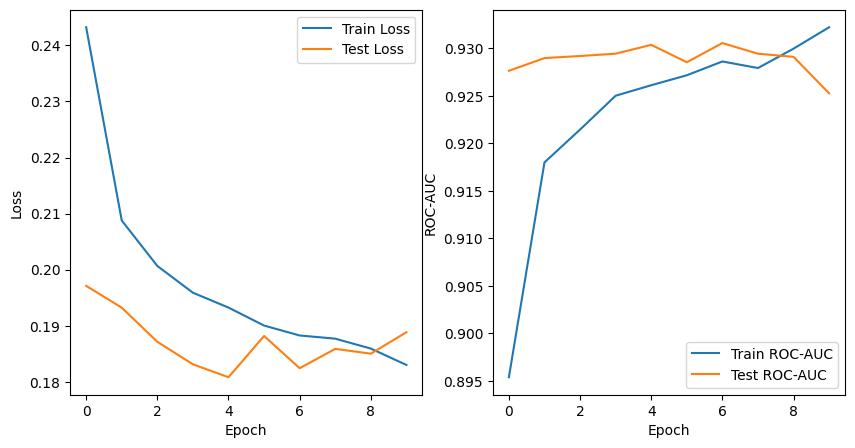

In [92]:
# Пример изменения dropout_prob на 0.2
model = ModelWithDropout(input_size=X_train_processed.shape[1], hidden_size=128, dropout_prob=0.2)
optimizer = optim.SGD(model.parameters(), lr=0.01)
train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10)

Epoch 1/10, Train Loss: 0.3244, Test Loss: 0.2594, Train ROC-AUC: 0.8078, Test ROC-AUC: 0.9081
Epoch 2/10, Train Loss: 0.2721, Test Loss: 0.2287, Train ROC-AUC: 0.8743, Test ROC-AUC: 0.9143
Epoch 3/10, Train Loss: 0.2601, Test Loss: 0.2225, Train ROC-AUC: 0.8833, Test ROC-AUC: 0.9176
Epoch 4/10, Train Loss: 0.2518, Test Loss: 0.2155, Train ROC-AUC: 0.8894, Test ROC-AUC: 0.9204
Epoch 5/10, Train Loss: 0.2445, Test Loss: 0.2143, Train ROC-AUC: 0.8960, Test ROC-AUC: 0.9224
Epoch 6/10, Train Loss: 0.2412, Test Loss: 0.2075, Train ROC-AUC: 0.8972, Test ROC-AUC: 0.9246
Epoch 7/10, Train Loss: 0.2365, Test Loss: 0.2039, Train ROC-AUC: 0.8998, Test ROC-AUC: 0.9259
Epoch 8/10, Train Loss: 0.2323, Test Loss: 0.2020, Train ROC-AUC: 0.9037, Test ROC-AUC: 0.9271
Epoch 9/10, Train Loss: 0.2276, Test Loss: 0.1990, Train ROC-AUC: 0.9059, Test ROC-AUC: 0.9284
Epoch 10/10, Train Loss: 0.2242, Test Loss: 0.1972, Train ROC-AUC: 0.9078, Test ROC-AUC: 0.9299


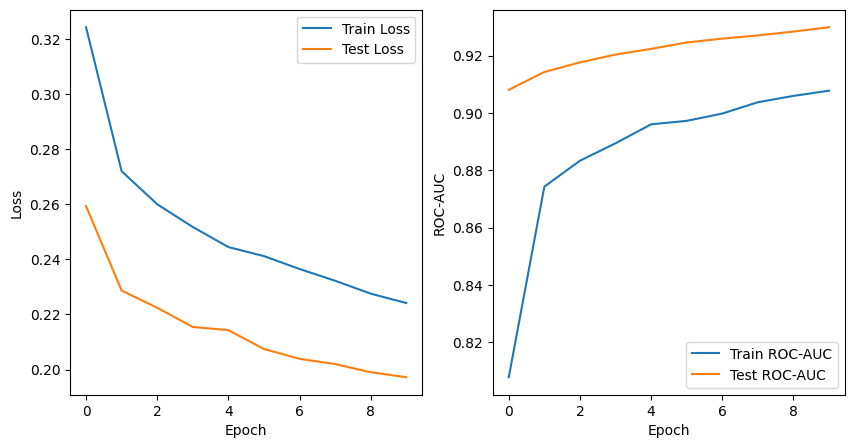

In [93]:
# Пример изменения dropout_prob на 0.9
model = ModelWithDropout(input_size=X_train_processed.shape[1], hidden_size=128, dropout_prob=0.9)
optimizer = optim.SGD(model.parameters(), lr=0.01)
train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10)

Низкие значения p (например, p = 0.01): Модель склонна к переобучению, что приводит к хорошим результатам на тренировочных данных, но тестовые показатели не улучшаются или даже ухудшаются.

Средние значения p (например, p = 0.1, p = 0.2): Модель обучается стабильно, достигая хороших результатов как на тренировочных, так и на тестовых данных. Эти значения p обеспечивают баланс между обучением и обобщением.

Высокие значения p (например, p = 0.9): Модель начинает с низкой производительности, но постепенно улучшается. Однако результаты на старте показывают, что обучение с таким значением p менее стабильное и требует больше времени для достижения хороших показателей.